In [1]:
import requests
import io
import random
import time
import os
import sys
import urllib
import numpy as np

# Image
from PIL import Image


# Selenium
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# Keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from traceback import print_exception
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras import applications

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 650M (CNMeM is enabled with initial size: 1.0% of memory, cuDNN 5110)


In [2]:
# CNN Setup

img_width, img_height = 100, 100

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


# build the VGG16 network
model_VGG = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

# VGG output shape to be fed in to FC layer
VGG_output_shape = (3, 3, 512)

# FC layer
model = Sequential()
model.add(Flatten(input_shape=VGG_output_shape))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

model.load_weights('model_weights/bottleneck_fc_model.h5')

In [12]:
def classify(f):
    img = load_img(f, grayscale=False, target_size=(img_width, img_height))
    img = img_to_array(img)/255
    img = np.expand_dims(img, axis=0)
    bottleneck_features = model_VGG.predict(img, batch_size=1)
    prediction = model.predict(bottleneck_features, batch_size=1)
    return prediction

In [13]:
def crop(filename, height, width):
    im = Image.open(filename)
    imgwidth, imgheight = im.size
    im_list = []
    k = 0
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            box = (j, i, j+width, i+height)
            a = im.crop(box)
            a.save('recaptchapics/cropped/out%s.jpg' % k)
            im_list.append(a)
            k += 1
    return im_list

In [3]:
# Randomization Related
MIN_RAND        = 0.64
MAX_RAND        = 1.27
LONG_MIN_RAND   = 4.78
LONG_MAX_RAND   = 11.1

RECAPTCHA_PAGE_URL = "https://www.google.com/recaptcha/api2/demo"

In [4]:
# selenium setup
chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

PROXY = 'http://us-il.proxymesh.com:31280'

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--proxy-server=%s' % PROXY)

driver = webdriver.Chrome(chromedriver, chrome_options=chrome_options)

In [5]:
# check IP
driver.get('http://whatismyipaddress.com/')

In [6]:
# open recaptcha demo page
driver.get(RECAPTCHA_PAGE_URL)

# get iframes (embedded html doc within parent html)
iframes = driver.find_elements_by_tag_name("iframe")
driver.switch_to_frame(iframes[0])

In [7]:
# click I'm not a robot checkbox
driver.find_element_by_xpath('//div[@class="recaptcha-checkbox-checkmark" and @role="presentation"]').click()

In [8]:
driver.switch_to.default_content()

# reload iframes
iframes = driver.find_elements_by_tag_name("iframe")

# get second (last) iframe once picture challenge is loaded
driver.switch_to_frame(iframes[-1])

In [15]:
# identify the type of challenge
challenge_type = driver.find_element_by_xpath('//div[@class="rc-imageselect-desc-no-canonical"]/strong').text

In [16]:
while challenge_type != 'mountains':
    # click refresh button
    driver.find_element_by_xpath('//button[@id="recaptcha-reload-button"]').click()
    time.sleep(0.5)
    challenge_type = driver.find_element_by_xpath('//div[@class="rc-imageselect-desc-no-canonical"]/strong').text

In [17]:
predictions_agg = []


# save original picture
original_path = 'recaptchapics/original/payload.jpg'
picture_url = driver.find_elements_by_xpath('//img[contains(@class, "rc-image-tile-")\
                                                    and contains(@src, "https://")]')[0].get_attribute('src')
urllib.request.urlretrieve(picture_url, original_path)

# crop and save individual pics and make sure no files exist in cropped directory
cropped_path = 'recaptchapics/cropped/'
for f in os.listdir(cropped_path):
    file_path = os.path.join(cropped_path, f)
    if not f.startswith('.'):
        os.remove(file_path)

crop(original_path, 100, 100)

predictions = []
    


# feed pics to CNN

for n, f in enumerate(os.listdir(cropped_path)):
    if not f.startswith('.'):
        file_path = os.path.join(cropped_path, f)
        prediction = classify(file_path)     # use int to make probabilities into binary
        print(n, prediction)
        
#       keep clicking on successive pictures until not mountain
        while prediction < 0.5:
            table = driver.find_elements_by_xpath('//tbody/tr/td')
            table[n].click()
            time.sleep(6)
            
            picture = driver.find_elements_by_xpath('//td//img')[n]
            picture_url = picture.get_attribute('src')
            f = 'out%s.jpg' % n
            file_path = os.path.join(cropped_path, f)
            urllib.request.urlretrieve(picture_url, file_path)
            prediction = classify(file_path)   # break out of while loop when image no longer a mountain
            print('while', n, prediction)
            
# click verify button
driver.find_element_by_xpath('//button[@id="recaptcha-verify-button"]').click()

0 [[  1.42959500e-09]]
while 0 [[  4.12381761e-12]]
while 0 [[ 1.]]
1 [[  4.88006469e-10]]
while 1 [[  1.44014060e-13]]
while 1 [[  6.54559772e-21]]
while 1 [[ 1.]]
2 [[  2.48863129e-15]]
while 2 [[ 1.]]
3 [[ 1.]]
4 [[ 0.9965108]]
5 [[  6.74390944e-19]]
while 5 [[  1.72897619e-14]]
while 5 [[ 1.]]
6 [[ 1.]]
7 [[ 1.]]
8 [[ 1.]]


In [178]:
predictions

[1, 1, 0, 0, 0, 1, 1, 0, 0]

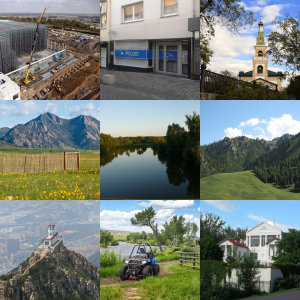

In [43]:
img = Image.open("recaptchapics/session3/original2/payload.jpeg")
img

In [44]:
cropped = crop('recaptchapics/session3/original2/payload.jpeg', 100, 100)

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from traceback import print_exception


# dimensions of our images.
img_width, img_height = 100, 100

test_data_dir = 'recaptchapics/session3/cropped2/'

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 650M (CNMeM is enabled with initial size: 1.0% of memory, cuDNN 5110)


In [291]:
from keras.models import load_model

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.load_weights('model_weights/second_try.h5')

In [292]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height), batch_size=1,
    class_mode='binary')

# predict = model.predict_generator(test_generator, 1)

FileNotFoundError: [Errno 2] No such file or directory: 'recaptchapics/session1/cropped1/'

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [276]:
img = load_img('recaptchapics/cropped/out0.jpg', grayscale=False, target_size=(img_width, img_height))
img = img_to_array(img)/255
img = np.expand_dims(img, axis=0)

In [277]:
predict = model.predict(img, batch_size=1, verbose=1)

1/1 [==============================] - 0s


In [278]:
predict

array([[ 0.92685455]], dtype=float32)

In [115]:
type(predict)

numpy.ndarray